In [21]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error 

import os
import time
import uuid

# Define the main directory where your container data directories are located
main_directory = '/home/razine.ghorab/projects/projectX/test_all/clustering/high_containers'  # Update with the correct path

# Get a list of subdirectories (each representing a container) within the main directory
container_directories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

# Create a DataFrame for your overall results
#results_df = pd.DataFrame(columns=['Container Name', 'MAE LSTM', 'MAE Past', 'Total CPU Data', 'Training Time Word2Vec', 'Training Time LSTM'])

# List of k_percentage values to try
k_values = [1,8,16,32,64]

# Initialize a master DataFrame to store results for all containers
master_df = pd.DataFrame()

# Set a counter variable to control the number of iterations
counter_limit = 2
counter = 0



# Process each container directory and its CSV file
for container_directory in container_directories:
    if counter >= counter_limit:
        break  # Exit the loop if the counter exceeds the limit
    
    #counter = counter + 1
    container_directory_path = os.path.join(main_directory, container_directory)

    # Find the CSV file inside the container directory
    csv_files = [f for f in os.listdir(container_directory_path) if f.endswith('original.csv')]

    if not csv_files:
        print(f"No CSV files found in the directory: {container_directory_path}")
        continue

    container_file_path = os.path.join(container_directory_path, csv_files[0])

    # Create a DataFrame for the current container
    
    container_df = pd.DataFrame(columns=['unique_id','mea_best_k1','mea_best_k8' ,'mea_best_k16' ,'mea_best_k32' ,'mea_best_k64' ,'accuracy_best_k1', 'accuracy_best_k8', 'accuracy_best_k16', 'accuracy_best_k32', 'accuracy_best_k64'])
    container_df.loc[0,'unique_id'] = csv_files[0].replace('.csv', '')
    print(csv_files[0])
    

    df = pd.read_csv(container_file_path)

    cpu_data = df['CPU Usage Percentage'].tolist()
    cpu_data = [str(cpu) for cpu in cpu_data]
    container_df.loc[0,'dict_len'] = len(set(cpu_data))

    sequence_length = len(cpu_data)
    sequences = [cpu_data[i * sequence_length:(i + 1) * sequence_length] for i in range(len(cpu_data) // sequence_length)]

    

    # Load and preprocess your data
    data = df
    cpu_values = data['CPU Usage Percentage'].values.astype(float)


    model = Word2Vec(sequences, vector_size=16, window=5, min_count=1, sg=1, compute_loss=True, epochs=200)
    





    for k_value in k_values:
        

        
        k = k_value 
        word_vectors = model.wv
        intersection_count = 0
        new_cpu_data_mea1=[]
       

        if len(cpu_data) > 3:
            for i in range(3, len(cpu_data)):
                # Get the previous 3 cpu_values

                cpu_values = [ cpu_data[i-3],cpu_data[i-2], cpu_data[i-1]]
                
                
                # Total number of context words
                n_words = len(cpu_values)
    
                # Compute weighted average vector
                # Linearly decreasing weights from n_words to 1
                weights = np.linspace(1, n_words, n_words)
                #weights=[1,1,1]
                weighted_vectors = np.zeros(word_vectors.vector_size)

                for word, weight in zip(cpu_values, weights):
                    if word in word_vectors:
                        weighted_vectors += word_vectors[word] * weight
                
                avg_vector = weighted_vectors / np.sum(weights)
                # Find the closest word to the average vector
                closest_words = word_vectors.similar_by_vector(avg_vector, topn=k)
                
                closest_words=[word for word, similarity in closest_words]
                
                # If the current cpu_value is in the intersection, you might want to count or track it
                if cpu_data[i] in closest_words:
                    intersection_count += 1
                    
                    new_cpu_data_mea1.append(cpu_data[i])
                    
                else:
                    
                    # Convert closest_words to a list of integers
                    numbers = list(map(int, closest_words))

                    # Sort the numbers based on their absolute difference from the target number
                    sorted_numbers = sorted(numbers, key=lambda x: abs(x - int(cpu_data[i])))

                    
                    # Take the 5 closest numbers
                    five_closest_numbers = sorted_numbers[:k]

                    # Convert these numbers to strings and append them to new_cpu_data
                    new_cpu_data_mea1.append(str(five_closest_numbers[0]))
                        
                



                    

            mae1_word2Vec = mean_absolute_error(list(map(int, cpu_data[3:])), list(map(int, new_cpu_data_mea1)))
            
            container_df.loc[0,'mea_best_k'+str(k_value)] = mae1_word2Vec

            container_df.loc[0,'accuracy_best_k'+str(k_value)] = intersection_count / (len(cpu_data) - 3)
            

    master_df = pd.concat([master_df, container_df], ignore_index=True)

# Save the results DataFrame to a CSV file
master_df.to_csv('k_in_knn_bench.csv', index=False)

print("Results saved to 'k_in_knn_bench.csv'")


text-service_net_erms_original.csv
nginx-web-server_net_erms_original.csv
socialnetwork-post-storage-mongodb_local_original.csv
recommendation_hotel_erms_original.csv
profile_hotel_erms_original.csv
reservation_hotel_erms_original.csv
socialnetwork-jaeger-agent_local_original.csv
url-shorten-mongodb_local_original.csv
socialnetwork-user-timeline-mongodb-1_original.csv
frontend_hotel_erms_original.csv
search_hotel_erms_original.csv
socialnetwork-home-timeline-redis-1_local_original.csv
compose-post-service_net_erms_original.csv
Results saved to 'k_in_knn_bench.csv'


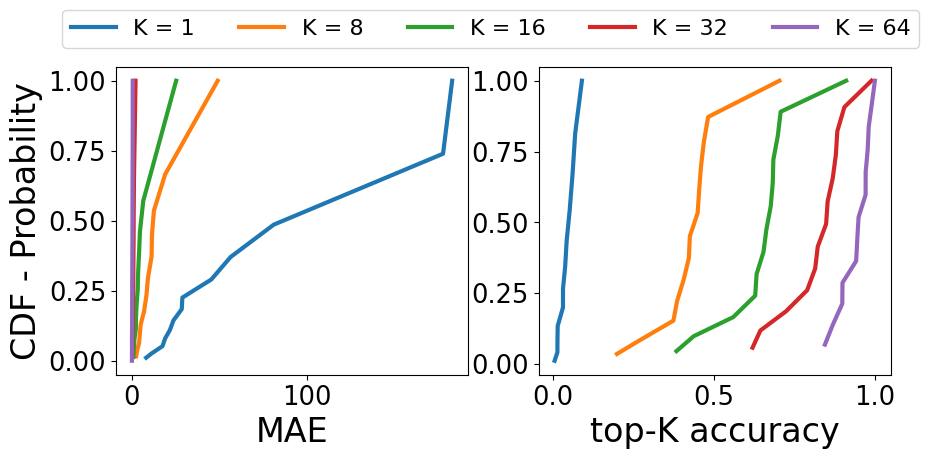

In [1]:

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Read the data
data_mae = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/k_in_knn_bench.csv')
data_acc = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/k_in_knn_bench.csv')

# Rename the columns
data_mae = data_mae.rename(columns={"mea_best_k1":"K = 1", "mea_best_k8": "K = 8", "mea_best_k16":"K = 16", "mea_best_k32":"K = 32", "mea_best_k64":"K = 64"})
data_acc = data_acc.rename(columns={"accuracy_best_k1":"K = 1", "accuracy_best_k8": "K = 8", "accuracy_best_k16":"K = 16", "accuracy_best_k32":"K = 32", "accuracy_best_k64":"K = 64"})

# Define the columns to plot
columns = ["K = 1", "K = 8", "K = 16", "K = 32", "K = 64"]

# Set a larger figure size to accommodate the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# List to store legend handles and labels
legend_handles = []
legend_labels = []

# Plot for MAE
for column in columns:
    forecasting = data_mae[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax1.plot(forecasting, cdf, label=f'{column}',lw=3)
    #legend_handles.append(handle)
    #legend_labels.append(f'{column}')

ax1.set_xlabel('MAE', fontsize=24)
ax1.set_ylabel('CDF - Probability',fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=18.5)

# Plot for Accuracy
for column in columns:
    forecasting = data_acc[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax2.plot(forecasting, cdf, label=f'{column}',lw=3)
    legend_handles.append(handle)
    legend_labels.append(f'{column}')

ax2.set_xlabel('top-K accuracy', fontsize=24)


ax2.tick_params(axis='both', which='major', labelsize=18.5)
#plt.xticks(fontsize=16)
# Create a single legend outside the figure
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=16)

plt.savefig("k_in_knn_new.pdf",format="pdf", bbox_inches="tight")
plt.show()

In [25]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error 
import os
import time
import uuid

# Define the main directory where your container data directories are located
main_directory = '/home/razine.ghorab/projects/projectX/test_all/clustering/high_containers'  # Update with the correct path

# Get a list of subdirectories (each representing a container) within the main directory
container_directories = [d for d in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, d))]

# Create a DataFrame for your overall results
#results_df = pd.DataFrame(columns=['Container Name', 'MAE LSTM', 'MAE Past', 'Total CPU Data', 'Training Time Word2Vec', 'Training Time LSTM'])

# List of k_percentage values to try
history_lengths = [1,3,6,10]

# Initialize a master DataFrame to store results for all containers
master_df = pd.DataFrame()

# Set a counter variable to control the number of iterations
counter_limit = 2
counter = 0



# Process each container directory and its CSV file
for container_directory in container_directories:
    if counter >= counter_limit:
        break  # Exit the loop if the counter exceeds the limit
    
    #counter = counter + 1
    container_directory_path = os.path.join(main_directory, container_directory)

    # Find the CSV file inside the container directory
    csv_files = [f for f in os.listdir(container_directory_path) if f.endswith('original.csv')]

    if not csv_files:
        print(f"No CSV files found in the directory: {container_directory_path}")
        continue

    container_file_path = os.path.join(container_directory_path, csv_files[0])

    # Create a DataFrame for the current container
    
    container_df = pd.DataFrame(columns=['unique_id'])
    container_df.loc[0,'unique_id'] = csv_files[0].replace('.csv', '')
    print(csv_files[0])
    

    df = pd.read_csv(container_file_path)

    cpu_data = df['CPU Usage Percentage'].tolist()
    cpu_data = [str(cpu) for cpu in cpu_data]
    container_df.loc[0,'dict_len'] = len(set(cpu_data))

    sequence_length = len(cpu_data)
    sequences = [cpu_data[i * sequence_length:(i + 1) * sequence_length] for i in range(len(cpu_data) // sequence_length)]

    # Initialize a dictionary to store results
    #result_dict = {'Container Name': csv_files[0]}

    # Load and preprocess your data
    data = df
    cpu_values = data['CPU Usage Percentage'].values.astype(float)


    model = Word2Vec(sequences, vector_size=16, window=5, min_count=1, sg=1, compute_loss=True, epochs=200)
    
    k=32





    for history_length in history_lengths:
        

        
        h = history_length 
        word_vectors = model.wv
        intersection_count = 0
        new_cpu_data_mea1=[]
       

        if len(cpu_data) > 3:
            for i in range(history_length, len(cpu_data)):
                # Get the previous 3 cpu_values

                if history_length == 1:
                    cpu_values = [cpu_data[i-1]]
                elif history_length == 3:
                    cpu_values = [ cpu_data[i-3],cpu_data[i-2], cpu_data[i-1]]
                elif history_length == 6:
                    cpu_values = [ cpu_data[i-6],cpu_data[i-5], cpu_data[i-4],cpu_data[i-3],cpu_data[i-2], cpu_data[i-1]]
                elif history_length == 10:
                    cpu_values = [ cpu_data[i-10],cpu_data[i-9],cpu_data[i-8], cpu_data[i-7],cpu_data[i-6],cpu_data[i-5], cpu_data[i-4],cpu_data[i-3],cpu_data[i-2], cpu_data[i-1]]

                
                
                
                # Total number of context words
                n_words = len(cpu_values)
    
                # Compute weighted average vector
                # Linearly decreasing weights from n_words to 1
                weights = np.linspace(1, n_words, n_words)
                #weights=[1,1,1]
                weighted_vectors = np.zeros(word_vectors.vector_size)

                for word, weight in zip(cpu_values, weights):
                    if word in word_vectors:
                        weighted_vectors += word_vectors[word] * weight
                
                avg_vector = weighted_vectors / np.sum(weights)
                # Find the closest word to the average vector
                closest_words = word_vectors.similar_by_vector(avg_vector, topn=k)
                closest_words=[word for word, similarity in closest_words]
                
                # If the current cpu_value is in the intersection, you might want to count or track it
                if cpu_data[i] in closest_words:
                    intersection_count += 1
                    new_cpu_data_mea1.append(cpu_data[i])
                    
                else:
                    
                    # Convert closest_words to a list of integers
                    numbers = list(map(int, closest_words))

                    # Sort the numbers based on their absolute difference from the target number
                    sorted_numbers = sorted(numbers, key=lambda x: abs(x - int(cpu_data[i])))

                    
                    # Take the 5 closest numbers
                    five_closest_numbers = sorted_numbers[:k]

                    # Convert these numbers to strings and append them to new_cpu_data
                    new_cpu_data_mea1.append(str(five_closest_numbers[0]))
                        
                



                    

            mae1_word2Vec = mean_absolute_error(list(map(int, cpu_data[history_length:])), list(map(int, new_cpu_data_mea1)))
            
            container_df.loc[0,'mea_best_h'+str(history_length)] = mae1_word2Vec
            container_df.loc[0,'accuracy_best_h'+str(history_length)] = intersection_count / (len(cpu_data) - history_length)
            


    master_df = pd.concat([master_df, container_df], ignore_index=True)

# Save the results DataFrame to a CSV file
master_df.to_csv('history_bench.csv', index=False)

print("Results saved to 'history_bench.csv'")


text-service_net_erms_original.csv
nginx-web-server_net_erms_original.csv
socialnetwork-post-storage-mongodb_local_original.csv
recommendation_hotel_erms_original.csv
profile_hotel_erms_original.csv
reservation_hotel_erms_original.csv
socialnetwork-jaeger-agent_local_original.csv
url-shorten-mongodb_local_original.csv
socialnetwork-user-timeline-mongodb-1_original.csv
frontend_hotel_erms_original.csv
search_hotel_erms_original.csv
socialnetwork-home-timeline-redis-1_local_original.csv
compose-post-service_net_erms_original.csv
Results saved to 'history_bench.csv'


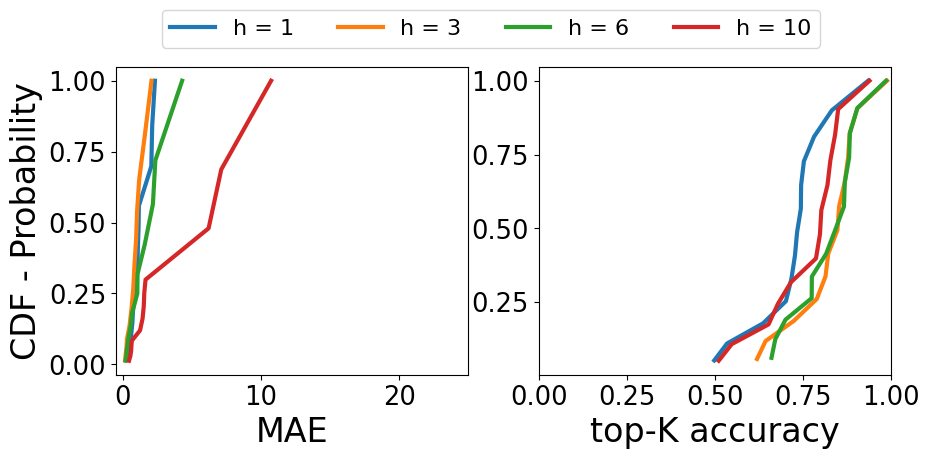

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Read the data
data_mae = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/history_bench.csv')
data_acc = pd.read_csv('/home/razine.ghorab/projects/projectX/paper_figures/history_bench.csv')

# Rename the columns
data_mae = data_mae.rename(columns={"mea_best_h1":"h = 1", "mea_best_h3": "h = 3", "mea_best_h6": "h = 6", "mea_best_h10":"h = 10"})
data_acc = data_acc.rename(columns={"accuracy_best_h1":"h = 1", "accuracy_best_h3": "h = 3", "accuracy_best_h6": "h = 6", "accuracy_best_h10":"h = 10"})

# Define the columns to plot
columns = ["h = 1", "h = 3", "h = 6", "h = 10"]

# Set a larger figure size to accommodate the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# List to store legend handles and labels
legend_handles = []
legend_labels = []

# Plot for MAE
for column in columns:
    forecasting = data_mae[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax1.plot(forecasting, cdf, label=f'{column}',lw=3)
    #legend_handles.append(handle)
    #legend_labels.append(f'{column}')

ax1.set_xlabel('MAE', fontsize=24)
ax1.set_xlim((-0.5,25))
ax1.set_ylabel('CDF - Probability',fontsize=24)
ax1.tick_params(axis='both', which='major', labelsize=18.5)

# Plot for Accuracy
for column in columns:
    forecasting = data_acc[column]
    forecasting = np.sort(forecasting)
    cdf = np.cumsum(forecasting) / np.sum(forecasting)
    handle, = ax2.plot(forecasting, cdf, label=f'{column}',lw=3)
    legend_handles.append(handle)
    legend_labels.append(f'{column}')

ax2.set_xlabel('top-K accuracy', fontsize=24)
ax2.set_xlim((0,1))
ax2.tick_params(axis='both', which='major', labelsize=18.5)

# Create a single legend outside the figure
fig.legend(legend_handles, legend_labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05), fontsize=16)

# Adjust layout to prevent overlapping of plots
plt.subplots_adjust(wspace=0.2)
plt.savefig("length_of_history_new.pdf",format="pdf", bbox_inches="tight")
# Show the plot
plt.show()